In [5]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [6]:

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Load JSON files
condition = load_json('/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/dbn/condition.json')
manifest = load_json('/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/dbn/manifest.json')
metadata = load_json('/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/metadata.json')

# Function to load CSV data
def load_csv(stock):
    file_path = f'/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/{stock}/20240624.csv'
    return pd.read_csv(file_path)

# Load data for each stock (1/10th of the dataset)
stocks = ['ASAI', 'CGAU', 'HL', 'RIOT']
data = {stock: load_csv(stock).sample(frac=0.1, random_state=1) for stock in stocks}

# Sort data by 'ts_event' for each stock
for stock in stocks:
    data[stock].sort_values(by='ts_event', inplace=True)


Processing stocks: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


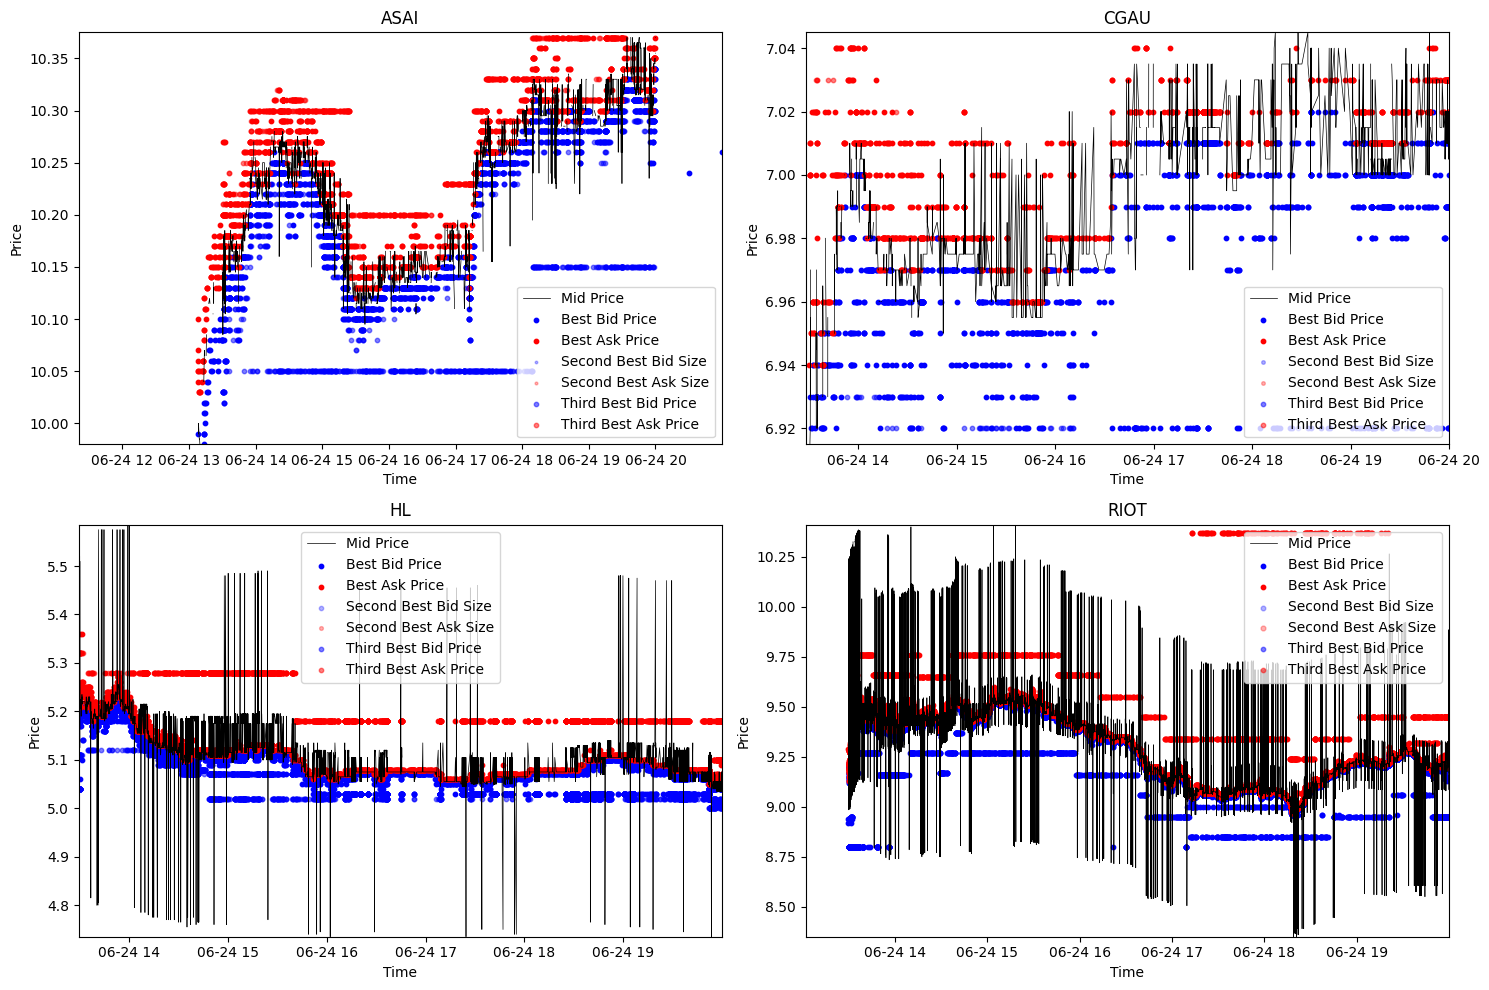

In [10]:
# Create a figure with subplots for each stock
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, stock in enumerate(tqdm(stocks, desc="Processing stocks")):
    df = data[stock]
    row = i // 2
    col = i % 2

    # Convert ts_event to datetime
    df['ts_event'] = pd.to_datetime(df['ts_event'], unit='ns')

    # Calculate the middle price
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2

    # Plot the middle price with a very thin line
    axs[row, col].plot(df['ts_event'], df['mid_price'], label='Mid Price', color='black', linewidth=0.5)

    # Plot the best bid price with a scatter plot
    axs[row, col].scatter(df['ts_event'], df['bid_px_00'], label='Best Bid Price', color='blue', s=10)

    # Plot the best ask price with a scatter plot
    axs[row, col].scatter(df['ts_event'], df['ask_px_00'], label='Best Ask Price', color='red', s=10)

    # Plot the second best bid size
    axs[row, col].scatter(df['ts_event'], df['bid_sz_01'], s=0.3*df['bid_sz_01']**0.5, color='blue', alpha=0.3, label='Second Best Bid Size')

    # Plot the second best ask size
    axs[row, col].scatter(df['ts_event'], df['ask_sz_01'], s=0.3*df['ask_sz_01']**0.5, color='red', alpha=0.3, label='Second Best Ask Size')

    # Plot the third best bid price (red transparent line)
    axs[row, col].scatter(df['ts_event'], df['bid_px_02'], label='Third Best Bid Price', color='blue', alpha=0.5, s=10)

    # Plot the third best ask price (red transparent line)
    axs[row, col].scatter(df['ts_event'], df['ask_px_02'], label='Third Best Ask Price', color='red', alpha=0.5, s=10)

    # Update axes
    axs[row, col].set_title(stock)
    axs[row, col].set_xlabel("Time")
    axs[row, col].set_ylabel("Price")
    axs[row, col].set_xlim(df['ts_event'].iloc[0], df['ts_event'].iloc[-1])
    axs[row, col].set_ylim(df['mid_price'].min(), df['mid_price'].max())
    axs[row, col].legend()

# Update layout
fig.tight_layout()

# Show the plot
plt.show()


In [15]:
import datetime
import os

# Function to load CSV data for a given date
def load_csv_for_date(stock, date):
    file_path = f'/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/{stock}/{date}.csv'
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No such file or directory: '{file_path}'")
    return pd.read_csv(file_path)

# Generate a list of dates for June, July, and specific days in August
june_dates = [(datetime.datetime.strptime("20240624", "%Y%m%d") + datetime.timedelta(days=x)).strftime("%Y%m%d") for x in range(5)]
july_dates = [(datetime.datetime.strptime("20240701", "%Y%m%d") + datetime.timedelta(days=x)).strftime("%Y%m%d") for x in range(31)]
august_dates = ["20240801", "20240802", "20240805", "20240806", "20240807", "20240808"]

# Combine all dates into one list
date_list = june_dates + july_dates + august_dates

# Load data for each stock and each date
data = {}
for stock in stocks:
    stock_data = []
    for date in date_list:
        try:
            stock_data.append(load_csv_for_date(stock, date).sample(frac=0.1, random_state=1))
        except FileNotFoundError as e:
            print(e)
    data[stock] = pd.concat(stock_data)

# Sort data by 'ts_event' for each stock
for stock in stocks:
    data[stock].sort_values(by='ts_event', inplace=True)


No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/ASAI/20240704.csv'
No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/ASAI/20240706.csv'
No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/ASAI/20240707.csv'
No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/ASAI/20240713.csv'
No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/ASAI/20240714.csv'
No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/ASAI/20240720.csv'
No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/ASAI/20240721.csv'
No such file or directory: '/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data

Processing stocks: 100%|██████████| 4/4 [00:41<00:00, 10.44s/it]
/tmp/ipykernel_298045/2267731064.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/tmp/ipykernel_298045/2267731064.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('/path/to/save/final_plot.png')


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/save/final_plot.png'

/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/venv/lib64/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


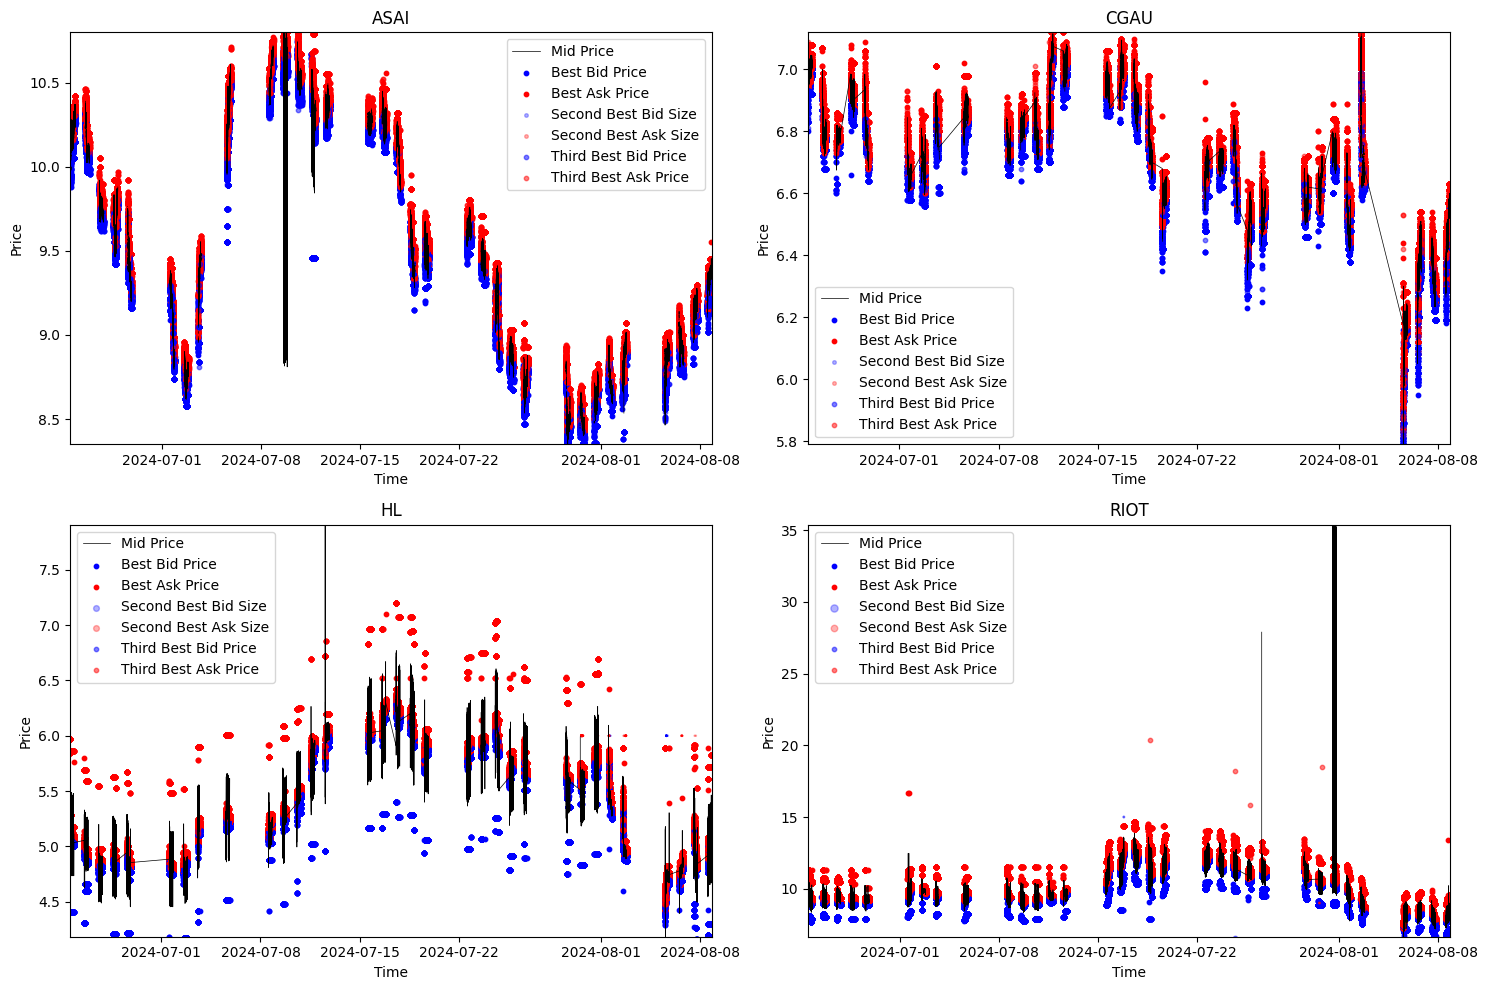

In [16]:

# Create a figure with subplots for each stock
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, stock in enumerate(tqdm(stocks, desc="Processing stocks")):
    df = data[stock]
    row = i // 2
    col = i % 2

    # Convert ts_event to datetime
    df['ts_event'] = pd.to_datetime(df['ts_event'], unit='ns')

    # Calculate the middle price
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2

    # Plot the middle price with a very thin line
    axs[row, col].plot(df['ts_event'], df['mid_price'], label='Mid Price', color='black', linewidth=0.5)

    # Plot the best bid price with a scatter plot
    axs[row, col].scatter(df['ts_event'], df['bid_px_00'], label='Best Bid Price', color='blue', s=10)

    # Plot the best ask price with a scatter plot
    axs[row, col].scatter(df['ts_event'], df['ask_px_00'], label='Best Ask Price', color='red', s=10)

    # Plot the second best bid size
    axs[row, col].scatter(df['ts_event'], df['bid_sz_01'], s=0.3*df['bid_sz_01']**0.5, color='blue', alpha=0.3, label='Second Best Bid Size')

    # Plot the second best ask size
    axs[row, col].scatter(df['ts_event'], df['ask_sz_01'], s=0.3*df['ask_sz_01']**0.5, color='red', alpha=0.3, label='Second Best Ask Size')

    # Plot the third best bid price (red transparent line)
    axs[row, col].scatter(df['ts_event'], df['bid_px_02'], label='Third Best Bid Price', color='blue', alpha=0.5, s=10)

    # Plot the third best ask price (red transparent line)
    axs[row, col].scatter(df['ts_event'], df['ask_px_02'], label='Third Best Ask Price', color='red', alpha=0.5, s=10)

    # Update axes
    axs[row, col].set_title(stock)
    axs[row, col].set_xlabel("Time")
    axs[row, col].set_ylabel("Price")
    axs[row, col].set_xlim(df['ts_event'].iloc[0], df['ts_event'].iloc[-1])
    axs[row, col].set_ylim(df['mid_price'].min(), df['mid_price'].max())
    axs[row, col].legend()

# Update layout
fig.tight_layout()

# Save the final plot as PNG
fig.savefig('/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/analyze/vizualize/plots/final_plot.png')

# Show the plot
plt.show()

# Plot each day separately and save as PNG
for date in date_list:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for i, stock in enumerate(stocks):
        df = load_csv_for_date(stock, date)
        row = i // 2
        col = i % 2

        # Convert ts_event to datetime
        df['ts_event'] = pd.to_datetime(df['ts_event'], unit='ns')

        # Calculate the middle price
        df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2

        # Plot the middle price with a very thin line
        axs[row, col].plot(df['ts_event'], df['mid_price'], label='Mid Price', color='black', linewidth=0.5)

        # Plot the best bid price with a scatter plot
        axs[row, col].scatter(df['ts_event'], df['bid_px_00'], label='Best Bid Price', color='blue', s=10)

        # Plot the best ask price with a scatter plot
        axs[row, col].scatter(df['ts_event'], df['ask_px_00'], label='Best Ask Price', color='red', s=10)

        # Plot the second best bid size
        axs[row, col].scatter(df['ts_event'], df['bid_sz_01'], s=0.3*df['bid_sz_01']**0.5, color='blue', alpha=0.3, label='Second Best Bid Size')

        # Plot the second best ask size
        axs[row, col].scatter(df['ts_event'], df['ask_sz_01'], s=0.3*df['ask_sz_01']**0.5, color='red', alpha=0.3, label='Second Best Ask Size')

        # Plot the third best bid price (red transparent line)
        axs[row, col].scatter(df['ts_event'], df['bid_px_02'], label='Third Best Bid Price', color='blue', alpha=0.5, s=10)

        # Plot the third best ask price (red transparent line)
        axs[row, col].scatter(df['ts_event'], df['ask_px_02'], label='Third Best Ask Price', color='red', alpha=0.5, s=10)

        # Update axes
        axs[row, col].set_title(stock)
        axs[row, col].set_xlabel("Time")
        axs[row, col].set_ylabel("Price")
        axs[row, col].set_xlim(df['ts_event'].iloc[0], df['ts_event'].iloc[-1])
        axs[row, col].set_ylim(df['mid_price'].min(), df['mid_price'].max())
        axs[row, col].legend()

    # Update layout
    fig.tight_layout()


    # Save the daily plot as PNG
    fig.savefig(f'/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/analyze/vizualize/plots/{date}_plot.png')

    # Show the plot
    plt.show()
